In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

# time vs. Tractor stage

In [54]:
df= pd.read_csv('/Users/kaylan1/Downloads/nobj_runs.txt',sep=' ')
df.head()

,nobj,brick,rsdir,frac_injected,tims,mask_junk,srcs,fitblobs,coadds,writecat
0,1000,1341p015,0,0.996,85.7,13.7,80.2,2467.5,260.4,0.5
1,1000,1341p015,1000,0.997,88.3,14.8,83.9,2580.5,272.2,0.6
2,1000,1423p167,0,0.996,119.5,17.8,89.7,4127.7,315.2,0.6
3,1000,1423p167,1000,0.996,119.5,17.4,89.1,3765.2,315.9,0.9
4,1000,1416p320,0,0.995,101.2,15.5,83.0,3528.3,325.7,1.0


In [55]:
avg= df.groupby(['nobj']).agg(np.mean).reset_index()
std= df.groupby(['nobj']).agg(np.std).reset_index()
avg.head()

,nobj,rsdir,frac_injected,tims,mask_junk,srcs,fitblobs,coadds,writecat
0,500,500,0.996000,88.092593,18.388889,91.711111,1911.592593,330.348148,0.429630
1,1000,500,0.995722,120.594444,18.600000,92.550000,4517.027778,337.855556,1.394444
2,1500,0,0.997333,162.677778,18.955556,94.155556,6219.966667,353.400000,0.911111


In [17]:
std.loc[avg['nobj'] == nobj,STAGES].values[0]

array([  1.34755313e+01,   3.47721521e+00,   7.73261491e+00,
         1.10847632e+03,   4.63918790e+01,   6.68800005e-02])

In [24]:
np.random.seed(7)

array([1, 0, 1, 0, 1, 1, 1, 1, 0, 1])

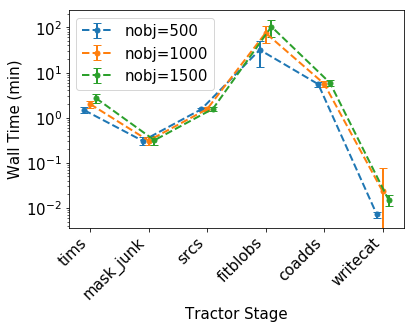

In [56]:
STAGES=['tims', 'mask_junk', 'srcs',
        'fitblobs', 'coadds', 'writecat']

import matplotlib as mpl
fontsize= 15
mpl.rcParams['axes.titlesize'] = fontsize
mpl.rcParams['axes.labelsize']= fontsize
mpl.rcParams['font.size']= fontsize

fig,ax=plt.subplots()
xvals= np.arange(len(STAGES))+1
for nobj,jitter in zip([500,1000,1500],[-0.1,0,0.1]):
    ax.errorbar(xvals+jitter, avg.loc[avg['nobj'] == nobj,STAGES].values[0]/60., 
                yerr= std.loc[avg['nobj'] == nobj,STAGES].values[0]/60.,
                fmt='o',label='nobj=%d' % nobj,
                lw=2,capsize=4,ms=5,ls='--')
ax.legend() #loc='lower right',scatterpoints=1)
ax.set_xticks(xvals)
ax.set_xticklabels(STAGES,rotation=45, ha='right')
ax.set_yscale('log')
#ax.set_ylim([1e-3,1e2])
xlab=ax.set_ylabel('Wall Time (min)')
ylab=ax.set_xlabel('Tractor Stage')
plt.savefig('time_per_stage_nobj.png', bbox_extra_artists=[xlab,ylab], 
            bbox_inches='tight',dpi=100)
#plt.close()

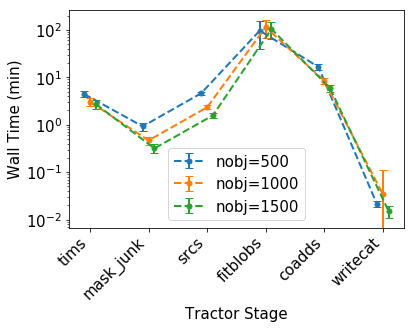

In [57]:
# nobj=1500 gets 3x and 1.5x more work done than nobj=500 and 1000
fig,ax=plt.subplots()
xvals= np.arange(len(STAGES))+1
for nobj,jitter in zip([500,1000,1500],[-0.1,0,0.1]):
    factor= 1500./nobj/avg.loc[avg['nobj'] == nobj,'frac_injected'].values[0]
    ax.errorbar(xvals+jitter, 
                avg.loc[avg['nobj'] == nobj,STAGES].values[0]/60.*factor, 
                yerr= std.loc[avg['nobj'] == nobj,STAGES].values[0]/60.*factor,
                fmt='o',label='nobj=%d' % nobj,
                lw=2,capsize=4,ms=5,ls='--')
ax.legend() #loc='lower right',scatterpoints=1)
ax.set_xticks(xvals)
ax.set_xticklabels(STAGES,rotation=45, ha='right')
ax.set_yscale('log')
#ax.set_ylim([1e-3,1e2])
xlab=ax.set_ylabel('Wall Time (min)')
ylab=ax.set_xlabel('Tractor Stage')
plt.savefig('time_per_stage_factor_nobj.png', bbox_extra_artists=[xlab,ylab], 
            bbox_inches='tight',dpi=100)
#plt.close()

# SLURM sacct 

In [4]:
a=pd.read_csv(os.path.join(os.environ["HOME"],'Downloads','my_sacct.txt'),
              delim_whitespace=True,header=None,
              names=['slurm_id','status','num_nodes','time'])



In [5]:
for i,name in zip([0,1,2],['multi_hr','min','sec']):
    a[name]= a['time'].str.split(':').str[i]

In [6]:
a['multi_hr'].str.split('-').str.len().value_counts()

1    295
2      1
Name: multi_hr, dtype: int64

In [8]:
hasExtra24= a['multi_hr'].str.split('-').str.len() > 1
a.loc[hasExtra24,'multi_hr'], a.loc[~hasExtra24,'multi_hr'].iloc[0]

(196    1-00
 Name: multi_hr, dtype: object, '00')

In [15]:
a['extra_hrs']= np.zeros(a.shape[0])
a.loc[hasExtra24,'extra_hrs']= 24*a.loc[hasExtra24,'multi_hr'].str.split('-').str[0].astype(float)
a['extra_hrs'].value_counts()

0.0     295
24.0      1
Name: extra_hrs, dtype: int64

In [16]:
a['hrs']= np.zeros(a.shape[0])
# No 01-05, just 05
a.loc[~hasExtra24,'hrs']= a.loc[~hasExtra24,'multi_hr'].astype(float)
# When 01-05, just take 05
a.loc[hasExtra24,'hrs']= a.loc[hasExtra24,'multi_hr'].str.split('-').str[1].astype(float)
a.loc[:,'hrs'] +=  a['extra_hrs']

In [18]:
a.loc[hasExtra24,'hrs'], a.loc[~hasExtra24,'hrs'].max()

(196    24.0
 Name: hrs, dtype: float64, 18.0)

In [21]:
for col in ['min','sec']:
    a.loc[:,col]= a.loc[:,col].astype(float)

In [37]:
def cpu_hrs(nodes,h,m,s, mpp=False,cori=True):
    """
    Args:
        nodes: number of nodes
        h,m,s: hours,min,sec
    """
    cores_per_node=32
    if not cori:
        cores_per_node=24
    mpp_factor= 1.
    if mpp:
        mpp_factor= 2.5
    
    return mpp_factor * cores_per_node * nodes * h + m/60. + s/3600.

a['cpu_hrs']= cpu_hrs(a['num_nodes'],a['hrs'],a['min'],a['sec'])
print('total cpu hours (M):',a['cpu_hrs'].sum()/1e6)
print('total MPP hours (M):',a['cpu_hrs'].sum()/1e6*2.5)

total cpu hours (M): 0.259007426667
total MPP hours (M): 0.647518566667


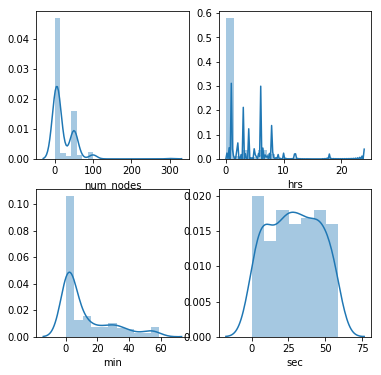

In [38]:
fig,ax= plt.subplots(2,2,figsize=(6,6))
names=['num_nodes','hrs','min','sec']
i=0
for row in range(2):
    for col in range(2):
        sns.distplot(a[names[i]],ax=ax[row,col])
        i+=1

# Parse log file for timings

In [95]:
from glob import glob
logfns= glob(os.path.join(os.environ['HOME'],'Downloads',
                     'logs/*/*/*/*/*'))
logfns= [os.path.join(fn,'log.1158p195') 
         for fn in logfns]
logfns

['/Users/kaylan1/Downloads/logs/n1200_notsorted/logs/115/1158p195/rs0/log.1158p195',
 '/Users/kaylan1/Downloads/logs/n1200_sorted/logs/115/1158p195/rs0/log.1158p195',
 '/Users/kaylan1/Downloads/logs/n300_notsorted/logs/115/1158p195/rs0/log.1158p195',
 '/Users/kaylan1/Downloads/logs/n300_sorted/logs/115/1158p195/rs0/log.1158p195',
 '/Users/kaylan1/Downloads/logs/n600_notsorted/logs/115/1158p195/rs0/log.1158p195',
 '/Users/kaylan1/Downloads/logs/n600_sorted/logs/115/1158p195/rs0/log.1158p195']

In [79]:
import re

def hours_elapsed_logfn(logfn):
    """returns hours between starting tims and finishing fitblobs
    robust to next day occuring etc.
    """
    with open(logfn,'r') as foo:
        text= foo.read()
    start= (re.findall(r'Running stage tims at.*?\n',text)[0]
               .split(' ')[-1]
               .replace('\n','')
               .split('.')[0]
               .replace('T',' ')
            )
    end= (re.findall(r'Stage fitblobs finished.*?\n',text)[0]
               .split(' ')[-1]
               .replace('\n','')
               .split('.')[0]
               .replace('T',' ')
         )
    start= pd.to_datetime(start, format='%Y-%m-%d %H:%M:%S')
    end= pd.to_datetime(end, format='%Y-%m-%d %H:%M:%S')
    return (end - start).total_seconds()/3600.

In [80]:
dtime= [hours_elapsed_logfn(logfn)
        for logfn in logfns]
dtime

[0.5491666666666667,
 0.7661111111111111,
 0.15861111111111112,
 0.2730555555555556,
 0.29944444444444446,
 0.43444444444444447]

In [89]:
df=pd.DataFrame(dict(time=dtime,
                  logfns=logfns))
df['name']=df['logfns'].str.split('/').str[5]
notSorted= df['name'].str.contains('notsorted')
print(df.loc[notSorted,['name','time']])
print(df.loc[~notSorted,['name','time']])

              name      time
0  n1200_notsorted  0.549167
2   n300_notsorted  0.158611
4   n600_notsorted  0.299444
           name      time
1  n1200_sorted  0.766111
3   n300_sorted  0.273056
5   n600_sorted  0.434444


In [96]:
#simcatfns= glob(os.path.join(os.environ['HOME'],'Downloads',
#                     'simcats/*/*/*/*/*'))
simcatfns= [(fn.replace('/Downloads/logs','/Downloads/simcats')
               .replace('/logs/','/obiwan/')
               .replace('log.1158p195','simcat-elg-1158p195.fits'))
            for fn in logfns]
simcatfns

['/Users/kaylan1/Downloads/simcats/n1200_notsorted/obiwan/115/1158p195/rs0/simcat-elg-1158p195.fits',
 '/Users/kaylan1/Downloads/simcats/n1200_sorted/obiwan/115/1158p195/rs0/simcat-elg-1158p195.fits',
 '/Users/kaylan1/Downloads/simcats/n300_notsorted/obiwan/115/1158p195/rs0/simcat-elg-1158p195.fits',
 '/Users/kaylan1/Downloads/simcats/n300_sorted/obiwan/115/1158p195/rs0/simcat-elg-1158p195.fits',
 '/Users/kaylan1/Downloads/simcats/n600_notsorted/obiwan/115/1158p195/rs0/simcat-elg-1158p195.fits',
 '/Users/kaylan1/Downloads/simcats/n600_sorted/obiwan/115/1158p195/rs0/simcat-elg-1158p195.fits']

In [99]:
from astrometry.util.fits import fits_table
num_srcs= [len(fits_table(fn))
           for fn in simcatfns]
num_srcs

[1044, 1133, 266, 300, 526, 587]

# 4x number sources takes ~ 3x as long, so beneficial to use more sources
* However, at 1200 takes ~ 1 hr and loose ~ 70 overlappers
* out of time errors will cose ~ 1 hr, so hurts using more sources
* May also run into mem error with more sources

### Try 1000 sources

In [103]:
df=pd.DataFrame(dict(time=dtime,
                     logfns=logfns,
                     num_srcs=num_srcs))
df['name']=df['logfns'].str.split('/').str[5]
notSorted= df['name'].str.contains('notsorted')
print(df.loc[notSorted,['name','time','num_srcs']])
print(df.loc[~notSorted,['name','time','num_srcs']])

              name      time  num_srcs
0  n1200_notsorted  0.549167      1044
2   n300_notsorted  0.158611       266
4   n600_notsorted  0.299444       526
           name      time  num_srcs
1  n1200_sorted  0.766111      1133
3   n300_sorted  0.273056       300
5   n600_sorted  0.434444       587


In [114]:
df['time_per_src']= df['time']/df['num_srcs']*3600
print(df.loc[notSorted,['name','time_per_src']])
print(df.loc[~notSorted,['name','time_per_src']])

              name  time_per_src
0  n1200_notsorted      1.893678
2   n300_notsorted      2.146617
4   n600_notsorted      2.049430
           name  time_per_src
1  n1200_sorted      2.434245
3   n300_sorted      3.276667
5   n600_sorted      2.664395


In [121]:
df.loc[~notSorted,'time_per_src'].values/df.loc[notSorted,'time_per_src'].values

array([ 1.28545886,  1.52643316,  1.30006669])

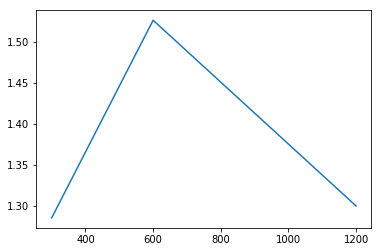

In [122]:
plt.plot([300,600,1200],
         df.loc[~notSorted,'time_per_src'].values/df.loc[notSorted,'time_per_src'].values)

In [40]:
start= pd.to_datetime(start, format='%Y-%m-%d %H:%M:%S')
end= pd.to_datetime(end, format='%Y-%m-%d %H:%M:%S')
start,end

(Timestamp('2017-12-11 12:57:14'), Timestamp('2017-12-11 13:30:11'))

In [43]:
dt= (end - start)

In [70]:
dt.total_seconds()

1977.0000000000002

In [51]:
start= pd.to_datetime('2017-12-11 00:10:10', format='%Y-%m-%d %H:%M:%S')
end= pd.to_datetime('2017-12-12 00:11:10', format='%Y-%m-%d %H:%M:%S')
(end - start).total_seconds()/3600.

24.016666666666666

In [53]:
df=pd.DataFrame(dict(start=[start]*4,
                     end=[end]*4))

In [54]:
(df['start'] - df['end']).total_seconds()

AttributeError: 'Series' object has no attribute 'total_seconds'

# number of tractor tables a given slurm file was able to make

In [125]:
from glob import glob
fn= os.path.join(os.environ['HOME'],'Downloads',
                     'slurm-8934400.out')
with open(fn,'r') as foo:
    text= foo.read()
start= (re.findall(r'Logging to:.*?\n',text)[0]
           .split(' ')[-1]
           .replace('\n','')
           .split('.')[0]
           .replace('T',' ')
        )

In [142]:
def add_fits(text):
    return text+'.fits'

def trac_fns(slurm_fn):
    with open(slurm_fn,'r') as foo:
        text= foo.read()
    return (pd.Series(re.findall(r'Logging to:.*?\n',text))
             .str.replace(r'Logging to:\s','')
             .str.strip()
             .str.replace('logs','tractor')
             .str.replace(r'log\.','tractor-')
             .apply(add_fits)
            ).values

a=trac_fns(fn)

In [144]:
]

'/global/cscratch1/sd/kaylanb/obiwan_out/elg_dr5/tractor/112/1127p272/rs0/tractor-1127p272.fits'